# Desafío - Enfermedad en la sangre

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
df = pd.read_csv('/content/hcvdat0.csv')
df.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [ ]:
#eliminamos la columna Unnamed
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [ ]:
#codificacion de la variable objetivo en dos categorias
df['target'] = df['Category'].apply(lambda x: 0 if x == '0=Blood Donor' else 1)
# Revisión inicial
print(df.head())
print(df['target'].value_counts())

        Category  Age Sex   ALB   ALP   ALT   AST   BIL    CHE  CHOL   CREA  \
0  0=Blood Donor   32   m  38.5  52.5   7.7  22.1   7.5   6.93  3.23  106.0   
1  0=Blood Donor   32   m  38.5  70.3  18.0  24.7   3.9  11.17  4.80   74.0   
2  0=Blood Donor   32   m  46.9  74.7  36.2  52.6   6.1   8.84  5.20   86.0   
3  0=Blood Donor   32   m  43.2  52.0  30.6  22.6  18.9   7.33  4.74   80.0   
4  0=Blood Donor   32   m  39.2  74.1  32.6  24.8   9.6   9.15  4.32   76.0   

    GGT  PROT  target  
0  12.1  69.0       0  
1  15.6  76.5       0  
2  33.2  79.3       0  
3  33.8  75.7       0  
4  29.9  68.7       0  
target
0    533
1     82
Name: count, dtype: int64


In [ ]:
# Crear columna 'suspect': 1 si '0s=suspect Blood Donor', 0 en caso contrario
df['suspect'] = df['Category'].apply(lambda x: 1 if x == '0s=suspect Blood Donor' else 0)

# Eliminar columna 'Category'
df.drop(columns=['Category'], inplace=True)

# Verificación
print(df[['target', 'suspect']].value_counts())

target  suspect
0       0          533
1       0           75
        1            7
Name: count, dtype: int64


In [ ]:
# 1. Revisar porcentaje de valores ausentes
missing_percent = df.isnull().mean() * 100
print("Porcentaje de valores ausentes por columna:\n", missing_percent)

# 2. Aplicar los criterios
for col in df.columns:
    if df[col].isnull().sum() > 0:
        perc = missing_percent[col]
        if perc < 1:
            df = df[df[col].notnull()]
        else:
            df.loc[:, col] = df.groupby('target')[col].transform(lambda x: x.fillna(x.mean()))
# Verificación final
print("\nValores nulos restantes después del tratamiento:")
print(df.isnull().sum())

Porcentaje de valores ausentes por columna:
 Age        0.000000
Sex        0.000000
ALB        0.162602
ALP        2.926829
ALT        0.162602
AST        0.000000
BIL        0.000000
CHE        0.000000
CHOL       1.626016
CREA       0.000000
GGT        0.000000
PROT       0.162602
target     0.000000
suspect    0.000000
dtype: float64

Valores nulos restantes después del tratamiento:
Age        0
Sex        0
ALB        0
ALP        0
ALT        0
AST        0
BIL        0
CHE        0
CHOL       0
CREA       0
GGT        0
PROT       0
target     0
suspect    0
dtype: int64


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

regresoras = ['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']

for col in regresoras:
    fig = px.histogram(df, x=col, nbins=30, title=f'Distribución de {col}',
                       marginal="box",  # agrega boxplot pequeño
                       color_discrete_sequence=['skyblue'])
    fig.update_layout(bargap=0.1)
    fig.show()

In [ ]:
import plotly.graph_objects as go

# Matriz de correlaciones
corr_matrix = df[regresoras].corr().round(2)

# Crear heatmap base
heatmap = go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='RdBu',
    zmin=-1,
    zmax=1,
    colorbar=dict(title='Correlación'),
    hoverongaps=False
)

# Anotaciones sobre cada celda
annotations = []
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix.columns)):
        annotations.append(
            dict(
                x=corr_matrix.columns[j],
                y=corr_matrix.index[i],
                text=str(corr_matrix.values[i][j]),
                showarrow=False,
                font=dict(color='black', size=12)
            )
        )

# Crear figura final con anotaciones
fig = go.Figure(data=[heatmap])
fig.update_layout(
    title='Matriz de Correlación entre Variables Regresoras',
    annotations=annotations,
    xaxis_nticks=36,
    width=800,
    height=700
)

fig.show()

In [ ]:
# Crear un resumen de outliers
outlier_summary = []

for col in regresoras:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = outliers.shape[0]
    total = df.shape[0]
    outlier_pct = round((outlier_count / total) * 100, 2)

    outlier_summary.append({
        'Variable': col,
        'Cantidad de Outliers': outlier_count,
        'Porcentaje (%)': outlier_pct
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df.sort_values(by='Porcentaje (%)', ascending=False)

,Variable,Cantidad de Outliers,Porcentaje (%)
9,GGT,65,10.62
4,AST,62,10.13
5,BIL,46,7.52
3,ALT,35,5.72
1,ALB,26,4.25
6,CHE,23,3.76
10,PROT,20,3.27
2,ALP,13,2.12
8,CREA,12,1.96
7,CHOL,12,1.96


In [ ]:
#Controlar Valores extremos de las variables
from scipy.stats.mstats import winsorize

# Variables con mayor proporción de outliers
variables_winsor = ['GGT', 'AST', 'BIL', 'ALT', 'ALB']

# Aplicar winsorizing (5% en ambos extremos)
for col in variables_winsor:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])

for col in regresoras:
    fig = px.histogram(
        df,
        x=col,
        nbins=30,
        title=f'Distribución de {col} después de Winsorizing',
        marginal="box",  # agrega boxplot pequeño arriba
        color_discrete_sequence=['skyblue']
    )
    fig.update_layout(bargap=0.1, title_x=0.5)
    fig.show()

In [ ]:
# 1. Boxplots antes de estandarizar
print("Boxplots antes de la estandarización:")
for col in regresoras:
    fig = px.box(df, y=col, title=f'Boxplot original de {col}', color_discrete_sequence=['skyblue'])
    fig.update_layout(title_x=0.5, width=600, height=400)
    fig.show()

# 2. Estandarizar variables regresoras
scaler = StandardScaler()
df_scaled_values = scaler.fit_transform(df[regresoras])

# Crear DataFrame con las variables estandarizadas
df_scaled = pd.DataFrame(df_scaled_values, columns=regresoras)

# 3. Boxplots después de estandarizar (todas en un solo plot para comparar)
df_melt_orig = df[regresoras].melt(var_name='Variable', value_name='Valor')
df_melt_scaled = df_scaled.melt(var_name='Variable', value_name='Valor')

df_melt_orig['Tipo'] = 'Original'
df_melt_scaled['Tipo'] = 'Estandarizada'

df_combined = pd.concat([df_melt_orig, df_melt_scaled])

fig = px.box(df_combined, x='Variable', y='Valor', color='Tipo',
             title='Boxplots antes y después de la estandarización',
             color_discrete_map={'Original':'indianred', 'Estandarizada':'royalblue'})
fig.update_layout(title_x=0.5, width=900, height=500)
fig.show()

# 4. División en train y test
X_train, X_test = train_test_split(df_scaled, test_size=0.33, random_state=42)

print(f"Tamaño entrenamiento: {X_train.shape}")
print(f"Tamaño test: {X_test.shape}")

Boxplots antes de la estandarización:


Tamaño entrenamiento: (410, 11)
Tamaño test: (202, 11)


In [ ]:
# Variables regresoras y target (usamos df_scaled para variables estandarizadas)
X = df_scaled
y = df['target']  # variable objetivo binaria que creamos antes

# División train-test (si no lo hiciste antes, puedes usar este bloque)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Definir rango hiperparámetros
Cs = np.linspace(0.01, 5, 200)
l1_ratios = np.linspace(0, 1, 200)

# Crear modelo con validación cruzada 5-fold, elastic net (penalty='elasticnet')
# solver debe ser 'saga' para elasticnet, max_iter aumentado para convergencia
logreg_cv = LogisticRegressionCV(
    cv=5,
    penalty='elasticnet',
    solver='saga',
    scoring='f1',
    max_iter=5000,
    tol=1e-4,
    Cs=Cs,
    l1_ratios=l1_ratios,
    refit=True,
    random_state=42,
    n_jobs=-1
)

# Entrenar modelo
logreg_cv.fit(X_train, y_train)

# Mejor hiperparámetros encontrados
best_C = logreg_cv.C_[0]
best_l1_ratio = logreg_cv.l1_ratio_[0]
print(f"Mejor C: {best_C:.4f}")
print(f"Mejor l1_ratio: {best_l1_ratio:.4f}")

# Predicciones en test
y_pred = logreg_cv.predict(X_test)

# Métricas
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Coeficientes (importancia de variables)
coef = logreg_cv.coef_[0]
coef_abs = np.abs(coef)
# Obtener nombres y coeficientes en dataframe
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': coef,
    'AbsCoef': coef_abs
})

# Top 3 variables con mayor impacto (coef absoluto)
top3 = coef_df.sort_values('AbsCoef', ascending=False).head(3)
print("\nTop 3 variables con mayor incidencia en la predicción:")
print(top3[['Variable', 'Coeficiente']])

Mejor C: 1.5897
Mejor l1_ratio: 0.0000
Precisión: 0.9600
Recall: 0.8000
F1-score: 0.8727
Accuracy: 0.9653

Top 3 variables con mayor incidencia en la predicción:
  Variable  Coeficiente
4      AST     2.002552
9      GGT     1.195542
3      ALT    -0.965208


El modelo es bastante preciso (cuando predice clase positiva, suele acertar).
Tiene un recall aceptable, aunque podría mejorarse si se quiere detectar más casos positivos.
F1-score balancea ambas cosas, y muestra buen rendimiento general.
Accuracy alto, pero recuerda que esta métrica puede estar sesgada si la clase 0 es mayoritaria.

| Variable                             | Coeficiente | Interpretación                                                                                       |
| ------------------------------------ | ----------- | ---------------------------------------------------------------------------------------------------- |
| **AST** (Aspartato aminotransferasa) | +2.00       | Aumenta la probabilidad de clase positiva (indicador fuerte de daño hepático).                       |
| **GGT** (Gamma-glutamil transferasa) | +1.196       | También se asocia fuertemente con enfermedad hepática.                                               |
| **ALT** (Alanina aminotransferasa)   | −0.97       | Sorprendentemente, tiene efecto negativo aquí (posiblemente asociado a normalidad en algunos casos). |


<ipython-input-107-2041874263>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




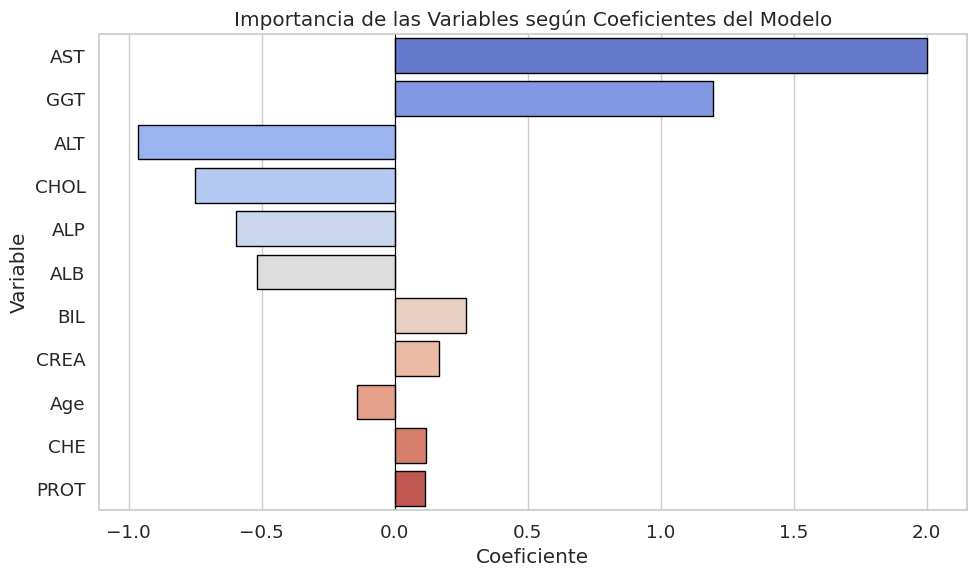

In [ ]:
# Crear DataFrame con los coeficientes del modelo
feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': logreg_cv.coef_.flatten()
})

# Ordenar por valor absoluto del coeficiente
feature_importance['abs_coef'] = feature_importance['Coeficiente'].abs()
feature_importance = feature_importance.sort_values(by='abs_coef', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance,
    x='Coeficiente',
    y='Variable',
    palette='coolwarm',
    edgecolor='black'
)

plt.title('Importancia de las Variables según Coeficientes del Modelo')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Definir el modelo base
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Definir la grilla de hiperparámetros
param_grid = {
    'reg_alpha': np.linspace(0, 1, 10),          # L1 regularization
    'reg_lambda': np.linspace(0, 2, 10),         # L2 regularization
    'learning_rate': np.linspace(0.1, 10, 20)    # Learning rate
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Entrenar
grid_search.fit(X_train, y_train)

# Predicción en test
y_pred = grid_search.best_estimator_.predict(X_test)

# Métricas
print(" Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\n Métricas en conjunto de test:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
 Mejores hiperparámetros encontrados:
{'learning_rate': np.float64(1.142105263157895), 'reg_alpha': np.float64(0.1111111111111111), 'reg_lambda': np.float64(2.0)}

 Métricas en conjunto de test:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       172
           1       0.89      0.80      0.84        30

    accuracy                           0.96       202
   macro avg       0.93      0.89      0.91       202
weighted avg       0.95      0.96      0.95       202

Accuracy: 0.9554455445544554


| Métrica   | LogReg ElasticNet | XGBoost    |
| --------- | ----------------- | ---------- |
| Precisión | 0.9600            | 0.95       |
| Recall    | 0.8000            | 0.80       |
| F1-score  | 0.8727            | 0.84       |
| Accuracy  | **0.9653**        | **0.9554** |


Ambos modelos tienen un rendimiento excelente.
La Regresión Logística logra una ligeramente mejor precisión y accuracy, pero XGBoost es más robusto y permite modelar relaciones no lineales.
Ambos modelos destacan a AST, GGT y ALT como variables clave para la predicción.